# LSTM with Paypal days data plus generation

In [374]:
import pandas as pd
import numpy as np
import datetime
import random
from itertools import cycle
from keras.models import Sequential
from keras.layers import Dense, LSTM
from math import sqrt, floor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

## Load Data

In [375]:
df_d = pd.read_csv("days_data.csv", index_col=0)
df_d.head()

,count,day_of_week
0,8.822189e+06,Saturday
1,1.065390e+07,Sunday
2,1.220661e+07,Monday
3,1.107984e+07,Tuesday
4,1.197607e+07,Wednesday


<AxesSubplot:>

<Figure size 1200x400 with 0 Axes>

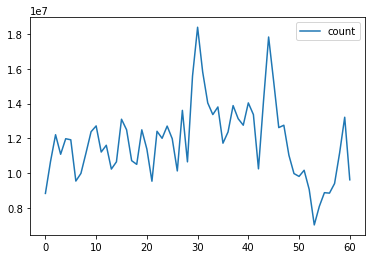

In [376]:
pyplot.figure(figsize=(15,5), dpi=80)
df_d.plot()

## Generate Days Data

In [377]:
# Keep getting data from our df_m (minute) data in a circular way
# This allows us to generate data and keep repeating until we run out of days in our dataset
def get_circular_data():
    circular_list = cycle(df_d.values)
    return circular_list

def generate_data(start, end, step, my_func):
    dt_first_timestamp_in_sec = int(start.timestamp())
    dt_first_timestamp_in_sec

    result = []
    while start < end:
        nextCycle = next(my_func)
        timestamp = start.strftime('%Y-%m-%d %H:%M:%S')
        result.append({"timestamp":timestamp,
                       "value": nextCycle[0],
                       "day_of_week": nextCycle[1]
                      })
        start += step
    return result

In [378]:
# Generate some data from Feb 1st 2019 to Feb 5th 2019
start = datetime.datetime(2000, 2, 1)
end = datetime.datetime(2021, 2, 5, 23, 59, 59)
step = datetime.timedelta(days=1) # By minutes (because we're using our minute dataset)

df = pd.DataFrame(generate_data(start,end,step,get_circular_data()))
df.head()

,timestamp,value,day_of_week
0,2000-02-01 00:00:00,8.822189e+06,Saturday
1,2000-02-02 00:00:00,1.065390e+07,Sunday
2,2000-02-03 00:00:00,1.220661e+07,Monday
3,2000-02-04 00:00:00,1.107984e+07,Tuesday
4,2000-02-05 00:00:00,1.197607e+07,Wednesday


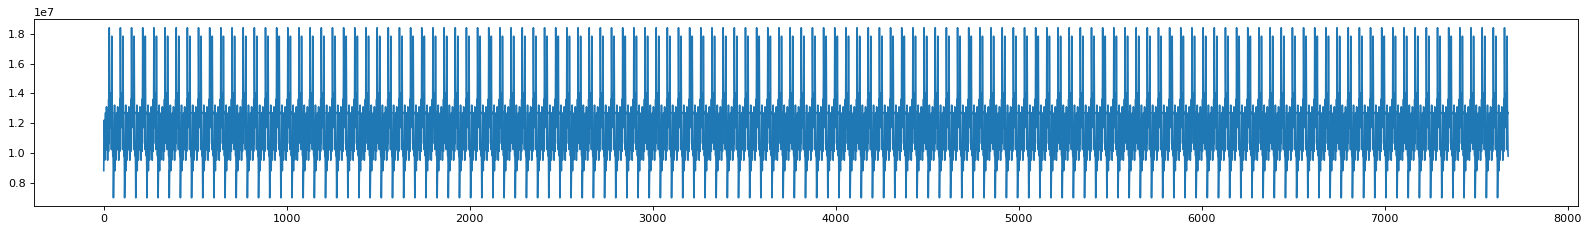

In [379]:
pyplot.figure(figsize=(20,3), dpi=80)
pyplot.plot(df["value"])
pyplot.tight_layout()
pyplot.show()

## Randomly Generating Other Columns

In [380]:
# Latency is loosely related to traffic volume
#  Although good systems don't see an increase in latency when the traffic increases
def latency(value):
    latency = 500 # 100 ms is the default
    
    if value > 9000:
        latency = latency * (1.01+random.uniform(0, 1))
    if value > 11000:
        latency = latency * (1.09+random.uniform(0, 1))
    if value < 5000:
        latency = latency * (0.7+random.uniform(0, 1))
    
    return latency
    
# We don't want to see many database errors, so let's simulate rare occurences
def db_errors(value, host_num):
    if host_num == 1:
        1 if random.randint(0,100000) > 77777 else np.NaN
    if host_num == 2:
        1 if random.randint(0,100000) > 99998 else np.NaN
    if host_num == 3:
        1 if random.randint(0,1000000) > 999999 else np.NaN
    
    return 1 if random.randint(0,100) > 99 else np.NaN

In [381]:
df["http_500"] = df["value"]*.05 # Server Error
df["http_404"] = df["value"]*.1 # Page not found
df["http_200"] = df["value"]*5 # OK

df["login_success"] = df["value"]*.6
df["latency"] = df["value"].apply(lambda x: latency(x))


df["db_errors_host01"] = df["value"].apply(lambda x: db_errors(x,1))
df["db_errors_host02"] = df["value"].apply(lambda x: db_errors(x,2))
df["db_errors_host03"] = df["value"].apply(lambda x: db_errors(x,3))

## Plots

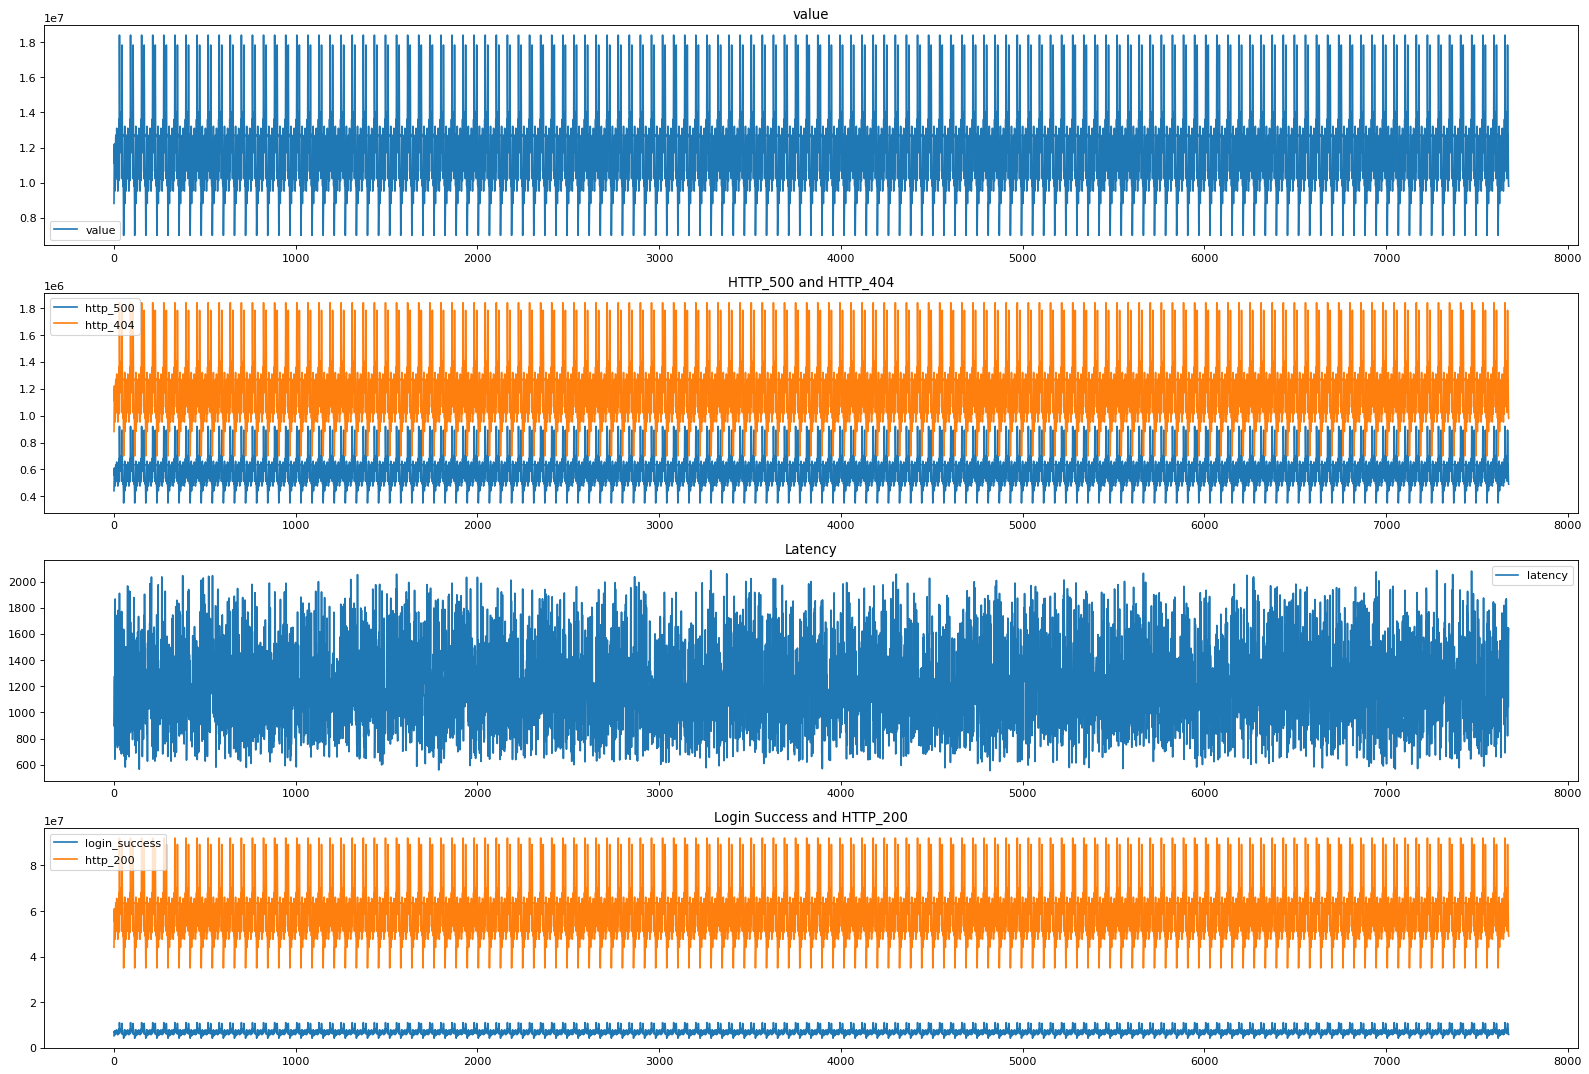

In [382]:
pyplot.figure(figsize=(20,20), dpi=80)
# plot each column
pyplot.subplot(6, 1, 1)
pyplot.plot(df["value"], label="value")
pyplot.title("value")
pyplot.legend()
pyplot.subplot(6, 1, 2)
pyplot.plot(df["http_500"], label="http_500")
pyplot.plot(df["http_404"], label="http_404")
pyplot.title("HTTP_500 and HTTP_404")
pyplot.legend()
pyplot.subplot(6, 1, 3)
pyplot.plot(df["latency"], label="latency")
pyplot.title("Latency")
pyplot.legend()
pyplot.subplot(6, 1, 4)
pyplot.plot(df["login_success"], label="login_success")
pyplot.plot(df["http_200"], label="http_200")
pyplot.title("Login Success and HTTP_200")
pyplot.legend()

pyplot.tight_layout()
pyplot.show()

# LSTM Application

## Function For Converting Time Series Data for Supervised Learning

In [383]:
# convert series to supervised learning
# developed in this blog post https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
	# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Preparing Data

In [384]:
df = df.set_index('timestamp')
df.head()

,value,day_of_week,http_500,http_404,http_200,login_success,latency,db_errors_host01,db_errors_host02,db_errors_host03
timestamp,,,,,,,,,,
2000-02-01 00:00:00,8.822189e+06,Saturday,441109.447195,8.822189e+05,4.411094e+07,5.293313e+06,898.077074,NaN,NaN,NaN
2000-02-02 00:00:00,1.065390e+07,Sunday,532694.917477,1.065390e+06,5.326949e+07,6.392339e+06,998.687685,NaN,NaN,NaN
2000-02-03 00:00:00,1.220661e+07,Monday,610330.683639,1.220661e+06,6.103307e+07,7.323968e+06,1231.470724,NaN,NaN,NaN
2000-02-04 00:00:00,1.107984e+07,Tuesday,553992.188851,1.107984e+06,5.539922e+07,6.647906e+06,1276.992755,NaN,NaN,NaN
2000-02-05 00:00:00,1.197607e+07,Wednesday,598803.716886,1.197607e+06,5.988037e+07,7.185645e+06,783.664795,NaN,NaN,NaN


In [385]:
# Replace Null values with 0's
df['db_errors_host01'].fillna(0, inplace=True)
df['db_errors_host02'].fillna(0, inplace=True)
df['db_errors_host03'].fillna(0, inplace=True)
df.head()

,value,day_of_week,http_500,http_404,http_200,login_success,latency,db_errors_host01,db_errors_host02,db_errors_host03
timestamp,,,,,,,,,,
2000-02-01 00:00:00,8.822189e+06,Saturday,441109.447195,8.822189e+05,4.411094e+07,5.293313e+06,898.077074,0.0,0.0,0.0
2000-02-02 00:00:00,1.065390e+07,Sunday,532694.917477,1.065390e+06,5.326949e+07,6.392339e+06,998.687685,0.0,0.0,0.0
2000-02-03 00:00:00,1.220661e+07,Monday,610330.683639,1.220661e+06,6.103307e+07,7.323968e+06,1231.470724,0.0,0.0,0.0
2000-02-04 00:00:00,1.107984e+07,Tuesday,553992.188851,1.107984e+06,5.539922e+07,6.647906e+06,1276.992755,0.0,0.0,0.0
2000-02-05 00:00:00,1.197607e+07,Wednesday,598803.716886,1.197607e+06,5.988037e+07,7.185645e+06,783.664795,0.0,0.0,0.0


In [386]:
values = df.values
# integer encoding of labels (not using yet here)
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])

In [387]:

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# Drop Columns of Variables We Aren't Predicting
reframed.drop(reframed.columns[[11, 12, 13, 14, 15, 16, 17, 18, 19]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var1(t)
1,0.159353,0.333333,0.159353,0.159353,0.159353,0.159353,0.224306,0.0,0.0,0.0,0.320064
2,0.320064,0.500000,0.320064,0.320064,0.320064,0.320064,0.290042,0.0,0.0,0.0,0.456297
3,0.456297,0.166667,0.456297,0.456297,0.456297,0.456297,0.442136,0.0,0.0,0.0,0.357436
4,0.357436,0.833333,0.357436,0.357436,0.357436,0.357436,0.471878,0.0,0.0,0.0,0.436070
5,0.436070,1.000000,0.436070,0.436070,0.436070,0.436070,0.149552,0.0,0.0,0.0,0.430628


In [388]:
# split into train and test sets
values = reframed.values
n_train_minutes = floor(len(values) * 0.1)
print(n_train_minutes)
train = values[:n_train_minutes, :]
test = values[n_train_minutes:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

767
(767, 1, 10) (767,) (6908, 1, 10) (6908,)


## Running LSTM

Epoch 1/50
11/11 - 2s - loss: 0.3726 - val_loss: 0.2972
Epoch 2/50
11/11 - 0s - loss: 0.2401 - val_loss: 0.1708
Epoch 3/50
11/11 - 0s - loss: 0.1373 - val_loss: 0.1159
Epoch 4/50
11/11 - 0s - loss: 0.1187 - val_loss: 0.1223
Epoch 5/50
11/11 - 0s - loss: 0.1181 - val_loss: 0.1152
Epoch 6/50
11/11 - 0s - loss: 0.1137 - val_loss: 0.1144
Epoch 7/50
11/11 - 0s - loss: 0.1130 - val_loss: 0.1129
Epoch 8/50
11/11 - 0s - loss: 0.1118 - val_loss: 0.1121
Epoch 9/50
11/11 - 0s - loss: 0.1111 - val_loss: 0.1113
Epoch 10/50
11/11 - 0s - loss: 0.1104 - val_loss: 0.1108
Epoch 11/50
11/11 - 0s - loss: 0.1101 - val_loss: 0.1106
Epoch 12/50
11/11 - 0s - loss: 0.1100 - val_loss: 0.1105
Epoch 13/50
11/11 - 0s - loss: 0.1099 - val_loss: 0.1104
Epoch 14/50
11/11 - 0s - loss: 0.1098 - val_loss: 0.1104
Epoch 15/50
11/11 - 0s - loss: 0.1097 - val_loss: 0.1102
Epoch 16/50
11/11 - 0s - loss: 0.1096 - val_loss: 0.1101
Epoch 17/50
11/11 - 0s - loss: 0.1095 - val_loss: 0.1101
Epoch 18/50
11/11 - 0s - loss: 0.1095 - 

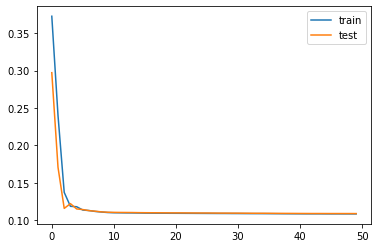

In [389]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [390]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [391]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
normalized_rmse = rmse/(max(max(inv_yhat),max(inv_y))-min(min(inv_yhat),min(inv_y)))
print('Normalized RMSE: %.3f' % normalized_rmse)

Test RMSE: 1688215.326
Normalized RMSE: 0.148


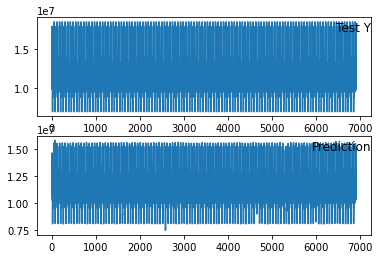

In [392]:
pyplot.subplot(2, 1, 1)
pyplot.plot(inv_y, label="Test Y")
pyplot.title("Test Y", y=0.8, loc='right')
pyplot.subplot(2, 1, 2)
pyplot.plot(inv_yhat, label="Prediction")
pyplot.title("Prediction", y=0.8, loc='right')
pyplot.show()